In [1]:
import torch
from torchvision.transforms import v2
from uuid import uuid4
import matplotlib.pyplot as plt

from data.download import mnist_loader

---

In [2]:
LR = 0.01
MOMENTUM = 0.9
EPOCHS = 1
BATCH_SIZE = 32
SAVE = True
GPU = torch.cuda.is_available()
ROOT = "./data"

/home/parxed/code/projects/VENVS/ml-scratch/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
TRANSFORMS = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))  # need to provide iterable
])

In [ ]:
train_loader = mnist_loader(root=ROOT, train=True, transforms=TRANSFORMS)
test_loader = mnist_loader(root=ROOT, train=False, transforms=TRANSFORMS)


def train(model, loader, criterion, optimizer):
    for epoch in range(EPOCHS):
        for img, label in loader:
            if GPU:
                img, label = img.to('cuda'), label.to('cuda')
            out = model(img).squeeze(axis=1)
            loss = criterion(out, label)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch} loss={loss.item()}")


def save(model):
    if SAVE:
        path = f"./models/saves/{uuid4()}-mlp"
        torch.save(model.state_dict(), path)
        print("Model saved under " + path)

- We squeeze the output matrix on axis 1, as the forward pass outputs shape [32, 1, 10]. 
- Cross-entropy loss expects class indices for target variable. `y` shape is [32], `y_hat` shape is [32, 10], where each of 32 points has raw outputs from output layer.

---

### Standard MLP w/ 3 layers (784 -> 512 -> 256 -> 10) using LeakyReLU activations

In [6]:
from models.mlp import MLP

mlp = MLP()
if GPU:
    mlp.to('cuda')
optimizer = torch.optim.SGD(mlp.parameters(), lr=LR, momentum=MOMENTUM)
criterion = torch.nn.CrossEntropyLoss()

##### Sample pass

In [ ]:
y = torch.tensor([0, 8, 1, 1, 3, 0, 2, 2, 3, 1, 1, 4, 6, 0, 6, 3, 9, 1, 5, 8, 1, 3, 2, 5, 0, 5, 9, 2, 5, 8, 8, 3])
y_hat = mlp(next(iter(train_loader))[0])
print(torch.nn.CrossEntropyLoss(y_hat.squeeze(axis=1), y))
print(y_hat.shape)

- `y`: 1 x 32, values ranging from (0, NUM_Y_HAT_COLS - 1)
- `y_hat`: 32 x 10

In [8]:
train(mlp, train_loader, criterion, optimizer)

---

### Convolution Operator

In [12]:
img = next(iter(mnist_loader(root=ROOT, train=True, transforms=TRANSFORMS)))[0][0]

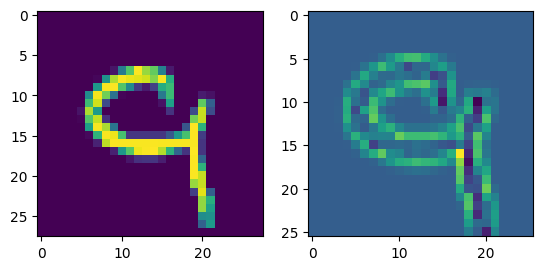

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img.squeeze())

filter = torch.tensor([[[1., 1., 1.],
                        [1., -5., 1.],
                        [1., 1., 1.]]])
convolved = torch.nn.functional.conv2d(img, filter.unsqueeze(0), stride=1, padding=0)
ax2.imshow(convolved.squeeze())

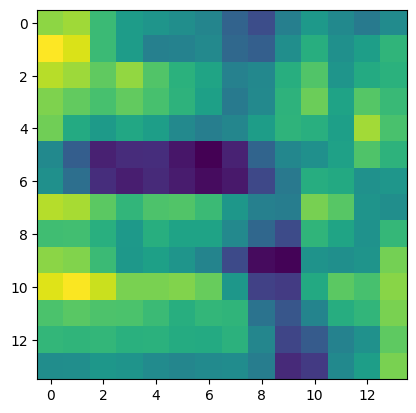

In [14]:
test_sequence = torch.nn.Sequential(
    torch.nn.Conv2d(1, 3, (2, 2)),
    torch.nn.AvgPool2d((5, 5), 1, 1),
    torch.nn.Conv2d(3, 1, (3, 3)),
    torch.nn.MaxPool2d((5, 5), 1, 1),
    torch.nn.Conv2d(1, 1, (8, 8))
)
plt.imshow(test_sequence(img).detach().numpy().squeeze())

---

In [10]:
from models.cnn import CNN_small

cnn_small = CNN_small()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_small.parameters(),
                            lr=0.01,
                            momentum=0.9)

train(cnn_small, train_loader, criterion, optimizer)